In [44]:
# librerias

import warnings
warnings.filterwarnings('ignore')


import pylab as plt
import pandas as pd
import seaborn as sns


from keras.utils import get_file

from keras import Sequential
from keras.layers import Dense

from keras.callbacks import Callback, EarlyStopping

from tensorflow.keras.optimizers.legacy import RMSprop

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from datetime import date, time, datetime, timedelta
import numpy as np

# Preparación del dataset  
Las columnas tienen los siguientes significados:  
- status (Housing status - a. ready for sale or b. ready to build)
- bed (# of beds)
- bath (# of bathrooms)
- acre_lot (Property / Land size in acres)
- city (city name)
- state (state name)
- zip_code (postal code of the area)
- house_size (house area/size/living space in square feet)
- prev_sold_date (Previously sold date)
- price (Housing price, it is either the current listing price or recently sold price if the house is sold recently)

In [45]:
df_realtor = pd.read_csv('realtor-data.csv')

In [46]:
df_realtor.head()

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
0,for_sale,105000.0,3.0,2.0,0.12,"Sector Yahuecas Titulo # V84, Adjuntas, PR, 00601",Sector Yahuecas Titulo # V84,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,for_sale,80000.0,4.0,2.0,0.08,"Km 78 9 Carr # 135, Adjuntas, PR, 00601",Km 78 9 Carr # 135,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,for_sale,67000.0,2.0,1.0,0.15,"556G 556-G 16 St, Juana Diaz, PR, 00795",556G 556-G 16 St,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,for_sale,145000.0,4.0,2.0,0.10,"R5 Comunidad El Paraso Calle De Oro R-5 Ponce,...",R5 Comunidad El Paraso Calle De Oro R-5 Ponce,Ponce,Puerto Rico,731.0,1800.0,NaN
4,for_sale,65000.0,6.0,2.0,0.05,"14 Navarro, Mayaguez, PR, 00680",14 Navarro,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [47]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512159 entries, 0 to 512158
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        512159 non-null  object 
 1   price         512159 non-null  float64
 2   bed           413222 non-null  float64
 3   bath          416941 non-null  float64
 4   acre_lot      407180 non-null  float64
 5   full_address  512159 non-null  object 
 6   street        511543 non-null  object 
 7   city          512100 non-null  object 
 8   state         512159 non-null  object 
 9   zip_code      511962 non-null  float64
 10  house_size    395693 non-null  float64
 11  sold_date     202507 non-null  object 
dtypes: float64(6), object(6)
memory usage: 46.9+ MB


Examinamos a ver si hay nulos

In [48]:
df_realtor.isna().sum()

status               0
price                0
bed              98937
bath             95218
acre_lot        104979
full_address         0
street             616
city                59
state                0
zip_code           197
house_size      116466
sold_date       309652
dtype: int64

Eliminamos todos los nulos, incluso en sold_date, porque nos interesan sólo las casas que han sido vendidas

In [49]:
df_realtor.dropna(inplace=True)

Cambiamos la columna sold_date a formato fecha

In [50]:
df_realtor['sold_date'] = pd.to_datetime(df_realtor['sold_date'], format='%Y-%m-%d', errors='coerce')

Creamos una nueva columna con el año de venta

In [51]:
def anio(x):
    return x.year
df_realtor['sold_year'] = df_realtor['sold_date'].apply(anio)

Creamos una nueva columna con las estaciones del año

In [52]:
def estaciones(x):
    dia_mes = datetime(x.year, x.month, x.day)
    primavera = datetime(x.year, 3, 21)
    verano = datetime(x.year, 6, 21)
    otoño = datetime(x.year, 9, 21)
    invierno = datetime(x.year, 12, 21)
    if primavera <= dia_mes < verano:
        return 'spring'
    elif verano <= dia_mes < otoño:
        return 'summer'
    elif otoño <= dia_mes < invierno:
        return 'autumn'
    else:  
        return 'winter'
df_realtor['sold_season'] = df_realtor['sold_date'].apply(estaciones)


Eliminamos la columna date porque ya hemos extraído la información que nos interesaba

In [53]:
df_realtor.drop('sold_date', axis=1, inplace=True)

Vamos a eliminar las columnas full_address, street y city puesto que esa info es redundante con la información que nos ofrece la columna State

In [54]:
df_realtor.drop('full_address', axis=1, inplace=True)
df_realtor.drop('street', axis=1, inplace=True)
df_realtor.drop('city', axis=1, inplace=True)
df_realtor.drop('zip_code', axis=1, inplace=True)

In [55]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141519 entries, 829 to 512154
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   status       141519 non-null  object 
 1   price        141519 non-null  float64
 2   bed          141519 non-null  float64
 3   bath         141519 non-null  float64
 4   acre_lot     141519 non-null  float64
 5   state        141519 non-null  object 
 6   house_size   141519 non-null  float64
 7   sold_year    141519 non-null  int64  
 8   sold_season  141519 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 10.8+ MB


Cambiamos las columnas de número de baños y habitaciones a números enteros

In [56]:
df_realtor['bed'] = df_realtor['bed'].astype(int)
df_realtor['bath'] = df_realtor['bath'].astype(int)

In [57]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141519 entries, 829 to 512154
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   status       141519 non-null  object 
 1   price        141519 non-null  float64
 2   bed          141519 non-null  int32  
 3   bath         141519 non-null  int32  
 4   acre_lot     141519 non-null  float64
 5   state        141519 non-null  object 
 6   house_size   141519 non-null  float64
 7   sold_year    141519 non-null  int64  
 8   sold_season  141519 non-null  object 
dtypes: float64(3), int32(2), int64(1), object(3)
memory usage: 9.7+ MB


Vemos como queda el dataset

In [58]:
df_realtor.head()

,status,price,bed,bath,acre_lot,state,house_size,sold_year,sold_season
829,for_sale,110000.0,7,3,0.09,Puerto Rico,1192.0,2019,summer
3380,for_sale,110000.0,7,3,0.09,Puerto Rico,1192.0,2019,summer
5083,for_sale,110000.0,7,3,0.09,Puerto Rico,1192.0,2019,summer
5387,for_sale,110000.0,7,3,0.09,Puerto Rico,1192.0,2019,summer
9053,for_sale,110000.0,7,3,0.09,Puerto Rico,1192.0,2019,summer


Vamos a observar las variables categóricas que nos quedan

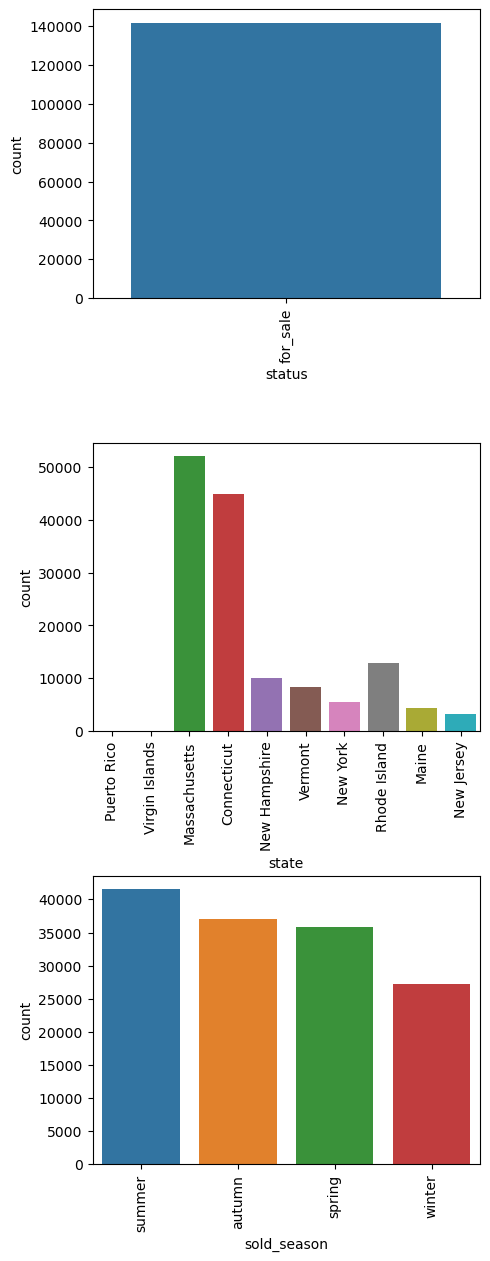

In [59]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,15))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(['status','state','sold_season']):
  sns.countplot(x=col, data=df_realtor, ax=ax[i])
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)

Eliminamos status, porque al eliminar todos los nulos, hemos eliminado las casas con la categoría ready to build.  
Esto significa que en EEUU no suelen venderse muchas casas sobre plano, es decir que no están construidas.

In [60]:
df_realtor.drop('status', axis=1, inplace=True)

In [61]:
df_realtor.state.value_counts()

Massachusetts     51961
Connecticut       44804
Rhode Island      12996
New Hampshire     10163
Vermont            8381
New York           5586
Maine              4421
New Jersey         3181
Puerto Rico          20
Virgin Islands        6
Name: state, dtype: int64

Puerto Rico y las Islas Vírgenes están en el Caribe. Vamos a crear un nuevo valor que sea Caribbean States  
Pennsylvania, New Jersey y West Virginia son estados del Este que están muy próximos entre sí y tienen pocos valores. Los agrupamos bajo N.Jersey and nearby

In [62]:
def agrupacion(x):
    if x == 'Virgin Islands':
        return 'Caribbean states'
    elif x == 'Puerto Rico':
        return 'Caribbean states'
    elif x == 'New Jersey':
        return 'N.Jersey and nearby'
    elif x == 'Pennsylvania':
        return 'N.Jersey and nearby'
    elif x == 'West Virginia':
        return 'N.Jersey and nearby'
    else:
        return x
df_realtor['state']=df_realtor['state'].apply(agrupacion)

Observamos las variables categóricas después de la limpieza

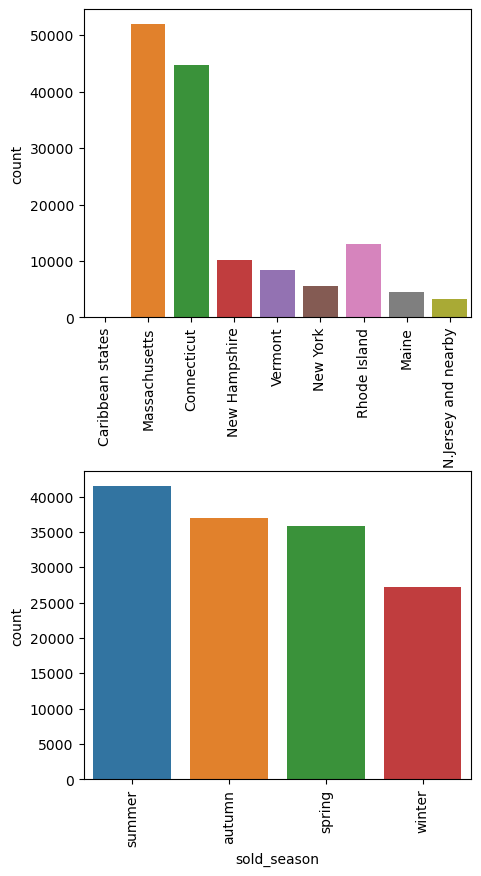

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,10))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(['state','sold_season']):
  sns.countplot(x=col, data=df_realtor, ax=ax[i])
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)

Vemos atípicos en variables numéricas

In [64]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141519 entries, 829 to 512154
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   price        141519 non-null  float64
 1   bed          141519 non-null  int32  
 2   bath         141519 non-null  int32  
 3   acre_lot     141519 non-null  float64
 4   state        141519 non-null  object 
 5   house_size   141519 non-null  float64
 6   sold_year    141519 non-null  int64  
 7   sold_season  141519 non-null  object 
dtypes: float64(3), int32(2), int64(1), object(2)
memory usage: 8.6+ MB


In [65]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141519 entries, 829 to 512154
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   price        141519 non-null  float64
 1   bed          141519 non-null  int32  
 2   bath         141519 non-null  int32  
 3   acre_lot     141519 non-null  float64
 4   state        141519 non-null  object 
 5   house_size   141519 non-null  float64
 6   sold_year    141519 non-null  int64  
 7   sold_season  141519 non-null  object 
dtypes: float64(3), int32(2), int64(1), object(2)
memory usage: 8.6+ MB


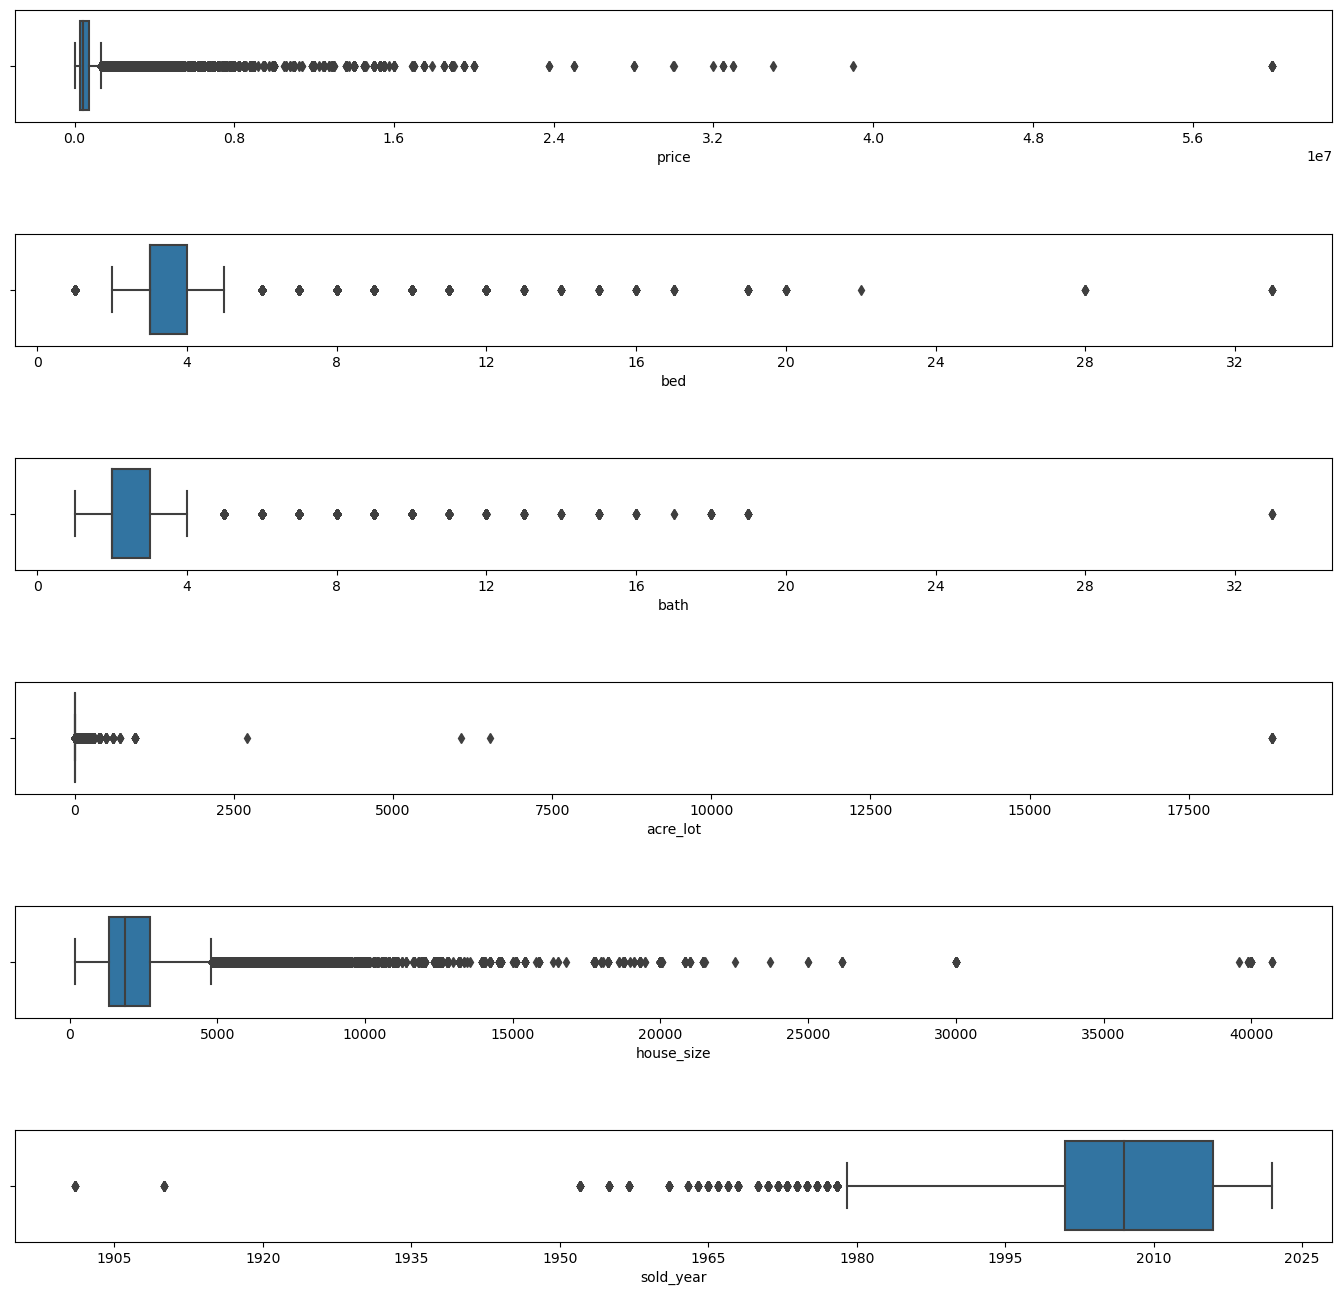

In [66]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,16))
fig.subplots_adjust(hspace=1)
for i, col in enumerate(['price', 'bed', 'bath', 'acre_lot', 'house_size', 'sold_year']):
    sns.boxplot(x=col, data=df_realtor, ax=ax[i])
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) # set a fixed number of ticks

Como vemos, hay muchos atípicos en la variable metros cuadrados. Esto puede deberse a que este dataset contiene propiedades muy grandes como mansiones, edificios enteros...  
También puede ser que haya errores tipográficos.  
Vamos a quitarnos las casas que tienen más baños que la media puesto que pueden tratarse de hoteles o edificios de oficinas y no de viviendas

In [67]:
print(f'Tamaño dataset anterior: {df_realtor.shape}')
#Creamos un df con la variable para recortar
variablerecorte = df_realtor[['bath']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que elimine los atipicos del nuevo dataframe
df_realtor = df_realtor[
    (df_realtor['bath']>=iqr_lim_inf) & (df_realtor['bath']<=iqr_lim_sup)
]
print(f'Tamaño dataset recortado: {df_realtor.shape}')

Tamaño dataset anterior: (141519, 8)
Tamaño dataset recortado: (131105, 8)


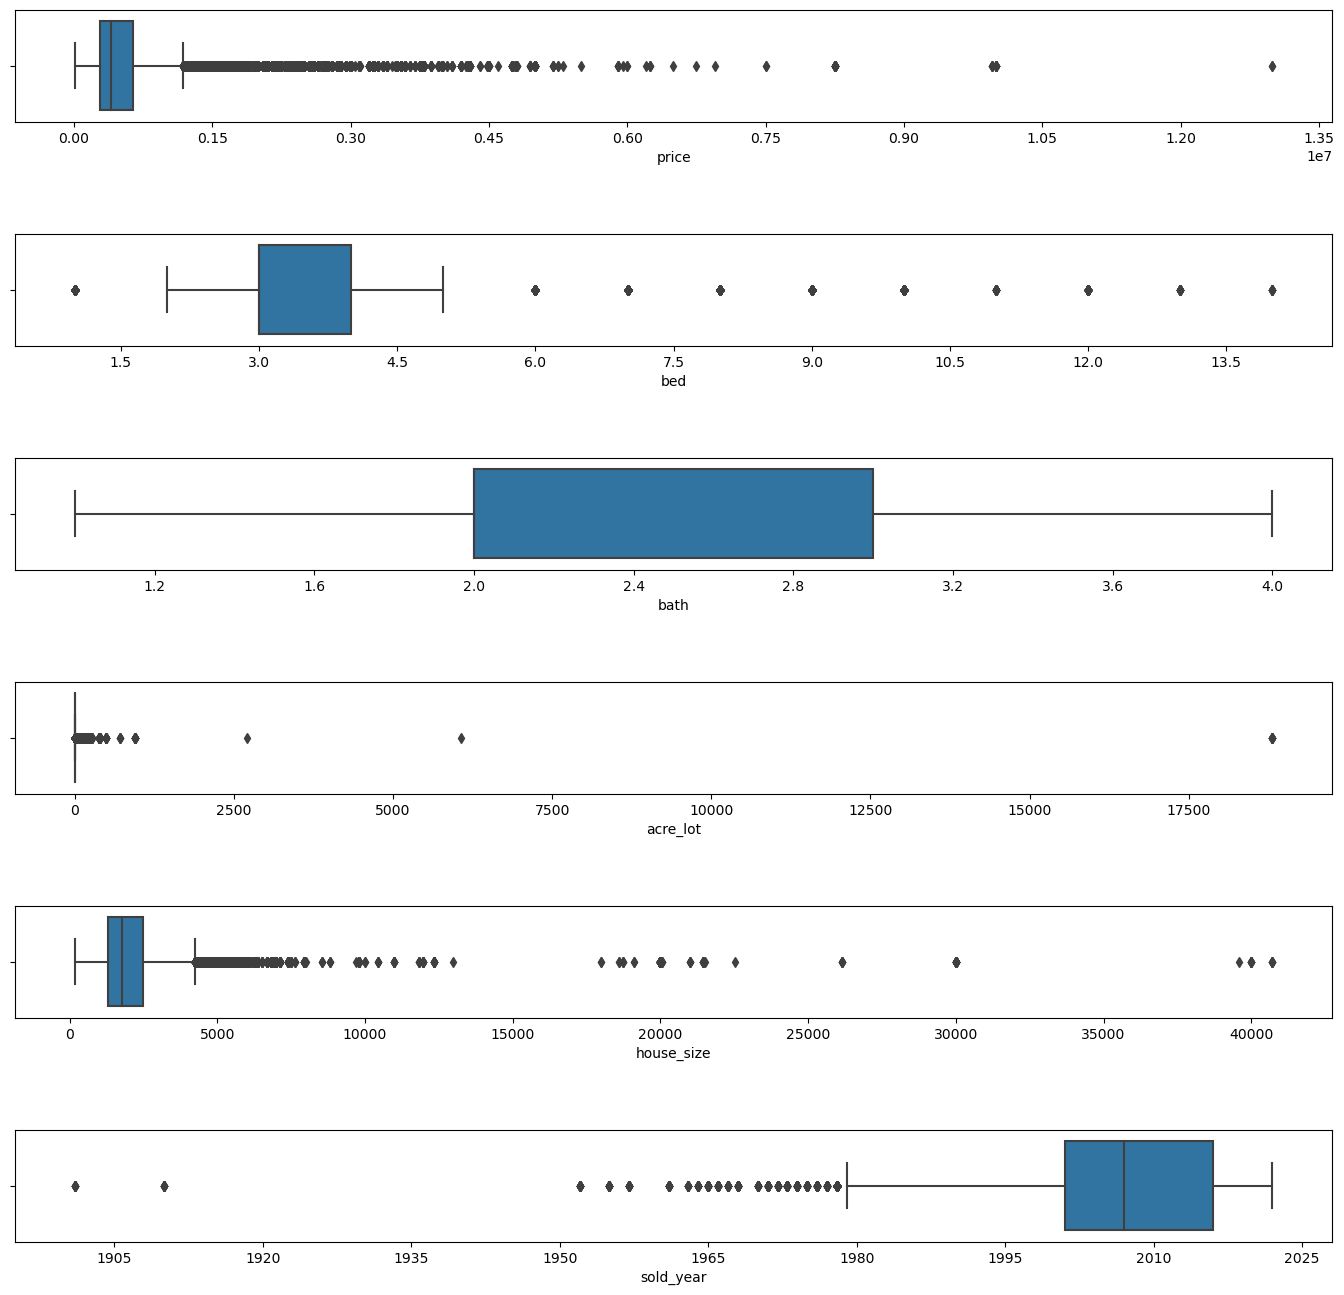

In [68]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,16))
fig.subplots_adjust(hspace=1)
for i, col in enumerate(['price', 'bed', 'bath', 'acre_lot', 'house_size', 'sold_year']):
    sns.boxplot(x=col, data=df_realtor, ax=ax[i])
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) # set a fixed number of ticks

Haremos lo mismo con las habitaciones. Aunque hayamos eliminado las propiedades con muchos baños, todavía nos quedan propiedades con demasiadas habitaciones.  
Pueden ser oficinas, hostales o pensiones con baños compartidos

In [69]:
print(f'Tamaño dataset anterior: {df_realtor.shape}')
#Creamos un df con la variable para recortar
variablerecorte = df_realtor[['bed']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que elimine los atipicos del nuevo dataframe
df_realtor = df_realtor[
    (df_realtor['bed']>=iqr_lim_inf) & (df_realtor['bed']<=iqr_lim_sup)
]
print(f'Tamaño dataset recortado: {df_realtor.shape}')

Tamaño dataset anterior: (131105, 8)
Tamaño dataset recortado: (118454, 8)


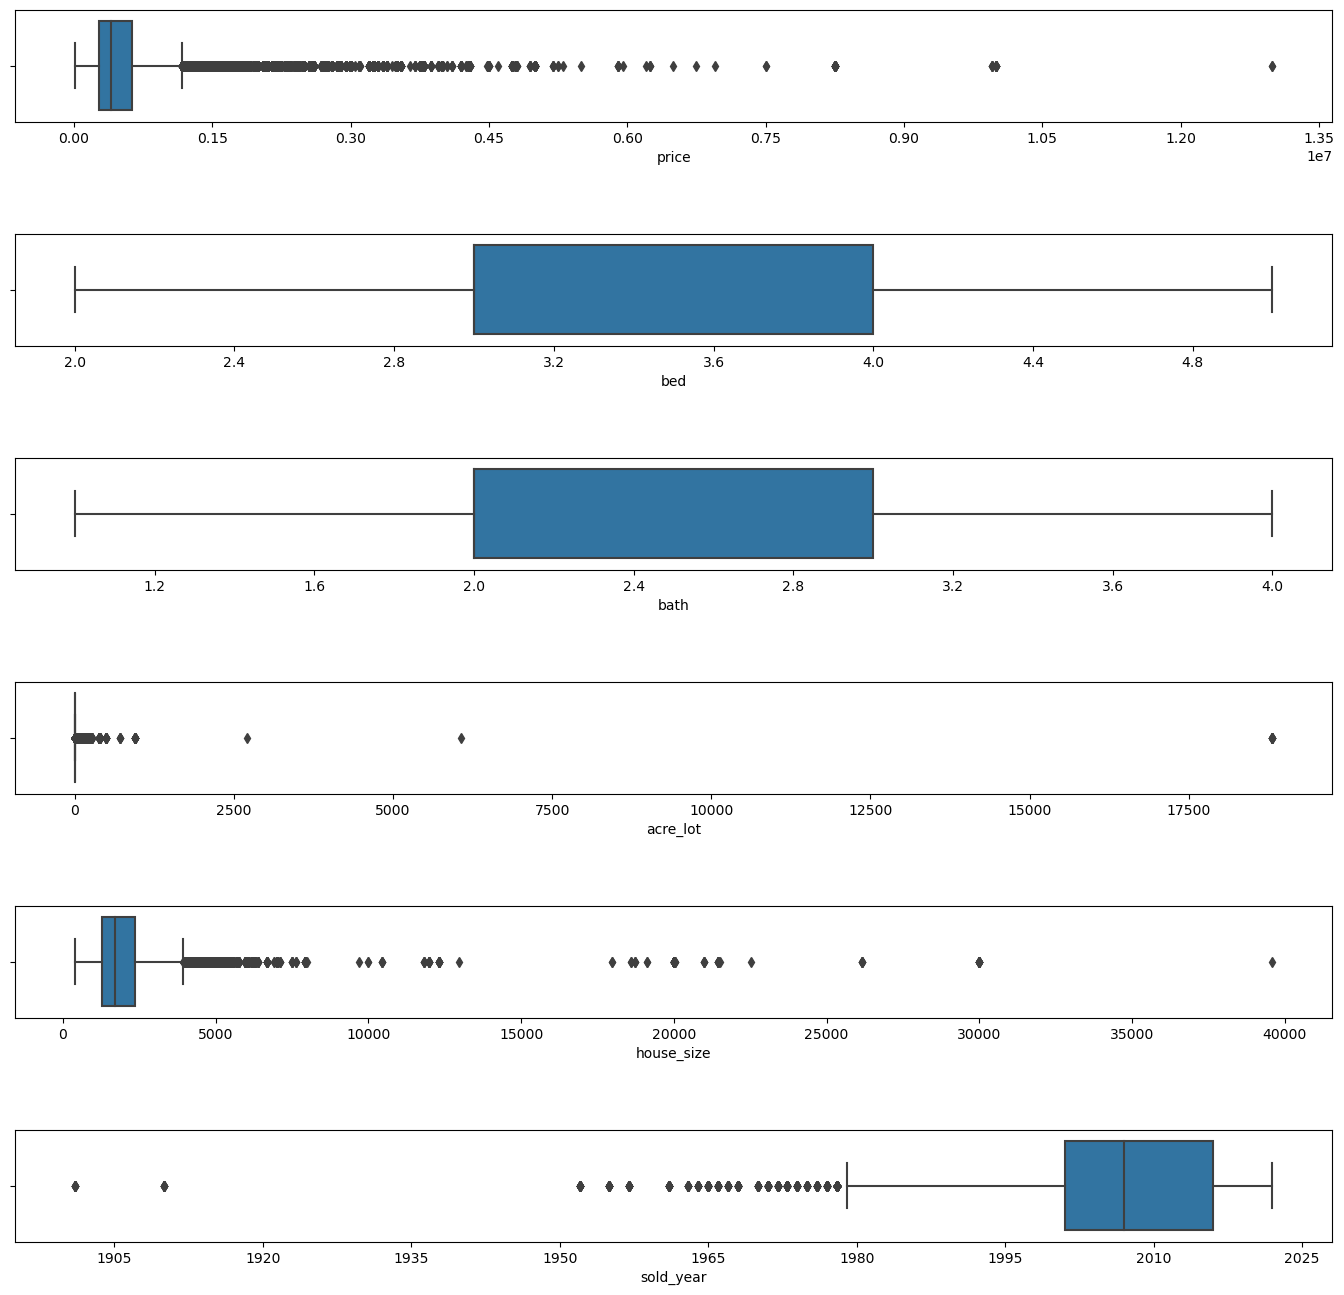

In [70]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,16))
fig.subplots_adjust(hspace=1)
for i, col in enumerate(['price', 'bed', 'bath', 'acre_lot', 'house_size', 'sold_year']):
    sns.boxplot(x=col, data=df_realtor, ax=ax[i])
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) # set a fixed number of ticks

También nos quitaremos los datos de aquellos años pasados de los cuales no tengamos muchos datos

In [71]:
print(f'Tamaño dataset anterior: {df_realtor.shape}')
#Creamos un df con la variable para recortar
variablerecorte = df_realtor[['sold_year']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que elimine los atipicos del nuevo dataframe
df_realtor = df_realtor[
    (df_realtor['sold_year']>=iqr_lim_inf) & (df_realtor['sold_year']<=iqr_lim_sup)
]
print(f'Tamaño dataset recortado: {df_realtor.shape}')

Tamaño dataset anterior: (118454, 8)
Tamaño dataset recortado: (117580, 8)


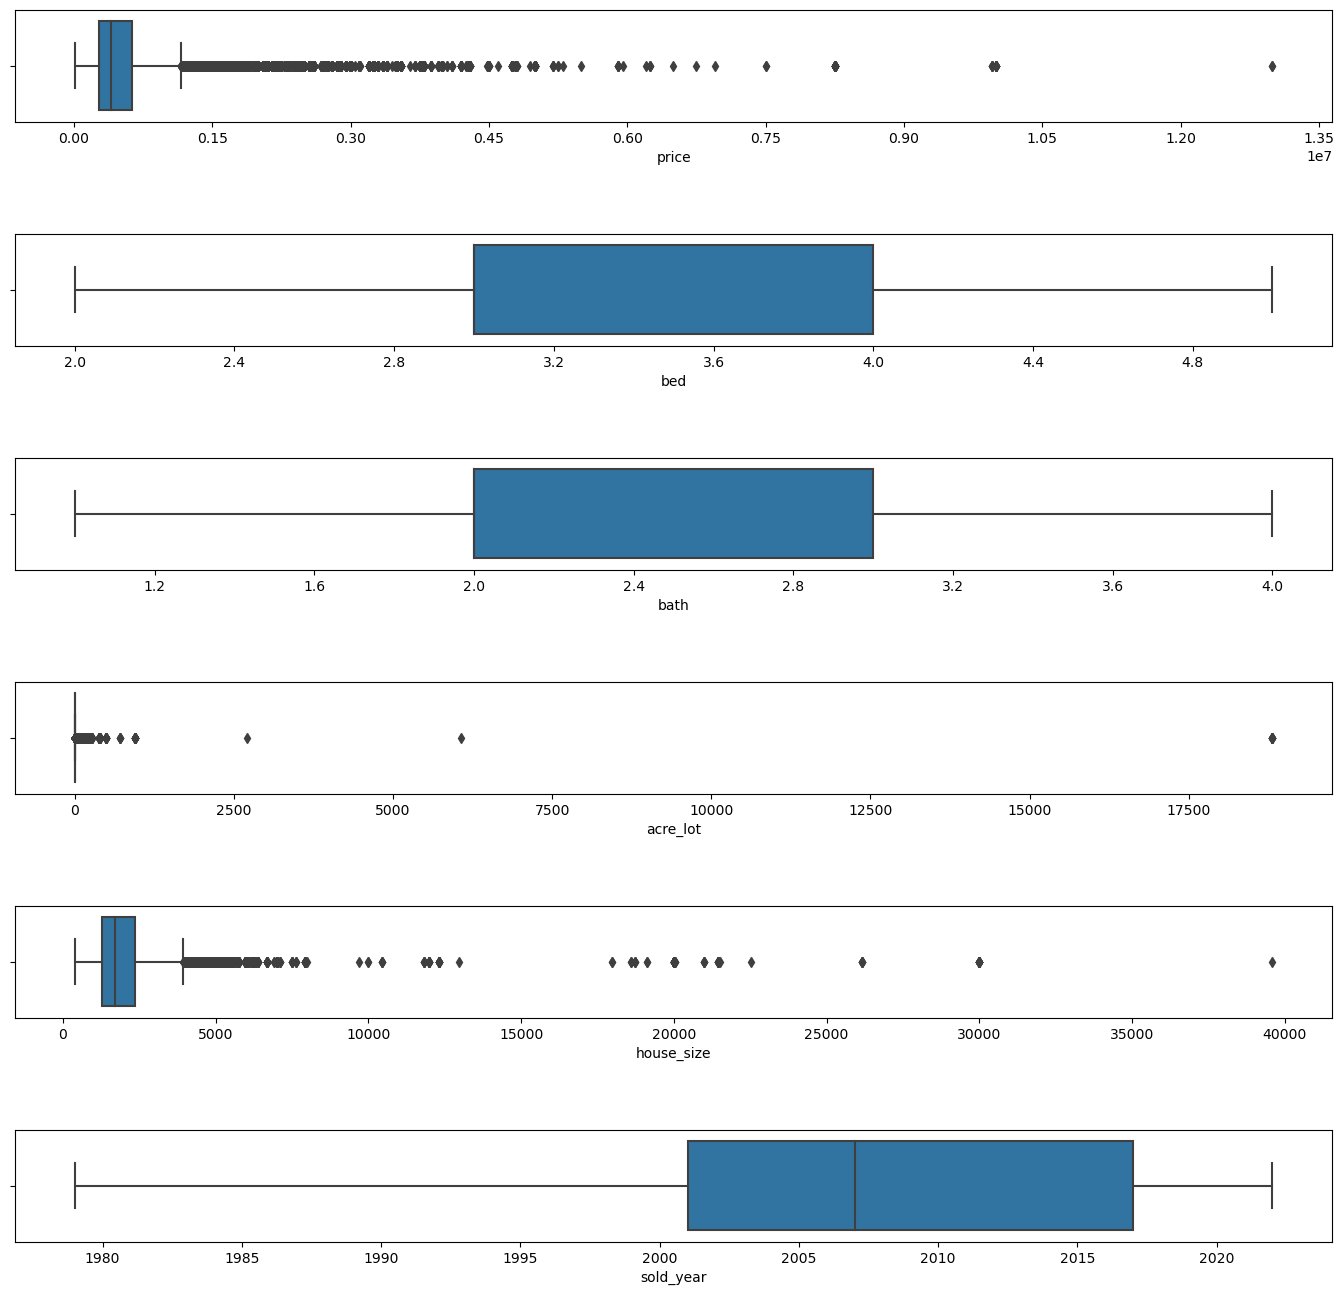

In [72]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,16))
fig.subplots_adjust(hspace=1)
for i, col in enumerate(['price', 'bed', 'bath', 'acre_lot', 'house_size', 'sold_year']):
    sns.boxplot(x=col, data=df_realtor, ax=ax[i])
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) # set a fixed number of ticks

Todavía nos quedan propiedades con muchos metros cuadrados (acre_lot) y muchos metros construidos(house_size). Pueden tratarse de fincas o mansiones grandes.  
Vamos a eliminar esos datos.

In [73]:
print(f'Tamaño dataset anterior: {df_realtor.shape}')
#Creamos un df con la variable para recortar
variablerecorte = df_realtor[['acre_lot']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que elimine los atipicos del nuevo dataframe
df_realtor = df_realtor[
    (df_realtor['acre_lot']>=iqr_lim_inf) & (df_realtor['acre_lot']<=iqr_lim_sup)
]
print(f'Tamaño dataset recortado: {df_realtor.shape}')

Tamaño dataset anterior: (117580, 8)
Tamaño dataset recortado: (104600, 8)


In [74]:
print(f'Tamaño dataset anterior: {df_realtor.shape}')
#Creamos un df con la variable para recortar
variablerecorte = df_realtor[['house_size']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que elimine los atipicos del nuevo dataframe
df_realtor = df_realtor[
    (df_realtor['house_size']>=iqr_lim_inf) & (df_realtor['house_size']<=iqr_lim_sup)
]
print(f'Tamaño dataset recortado: {df_realtor.shape}')

Tamaño dataset anterior: (104600, 8)
Tamaño dataset recortado: (100826, 8)


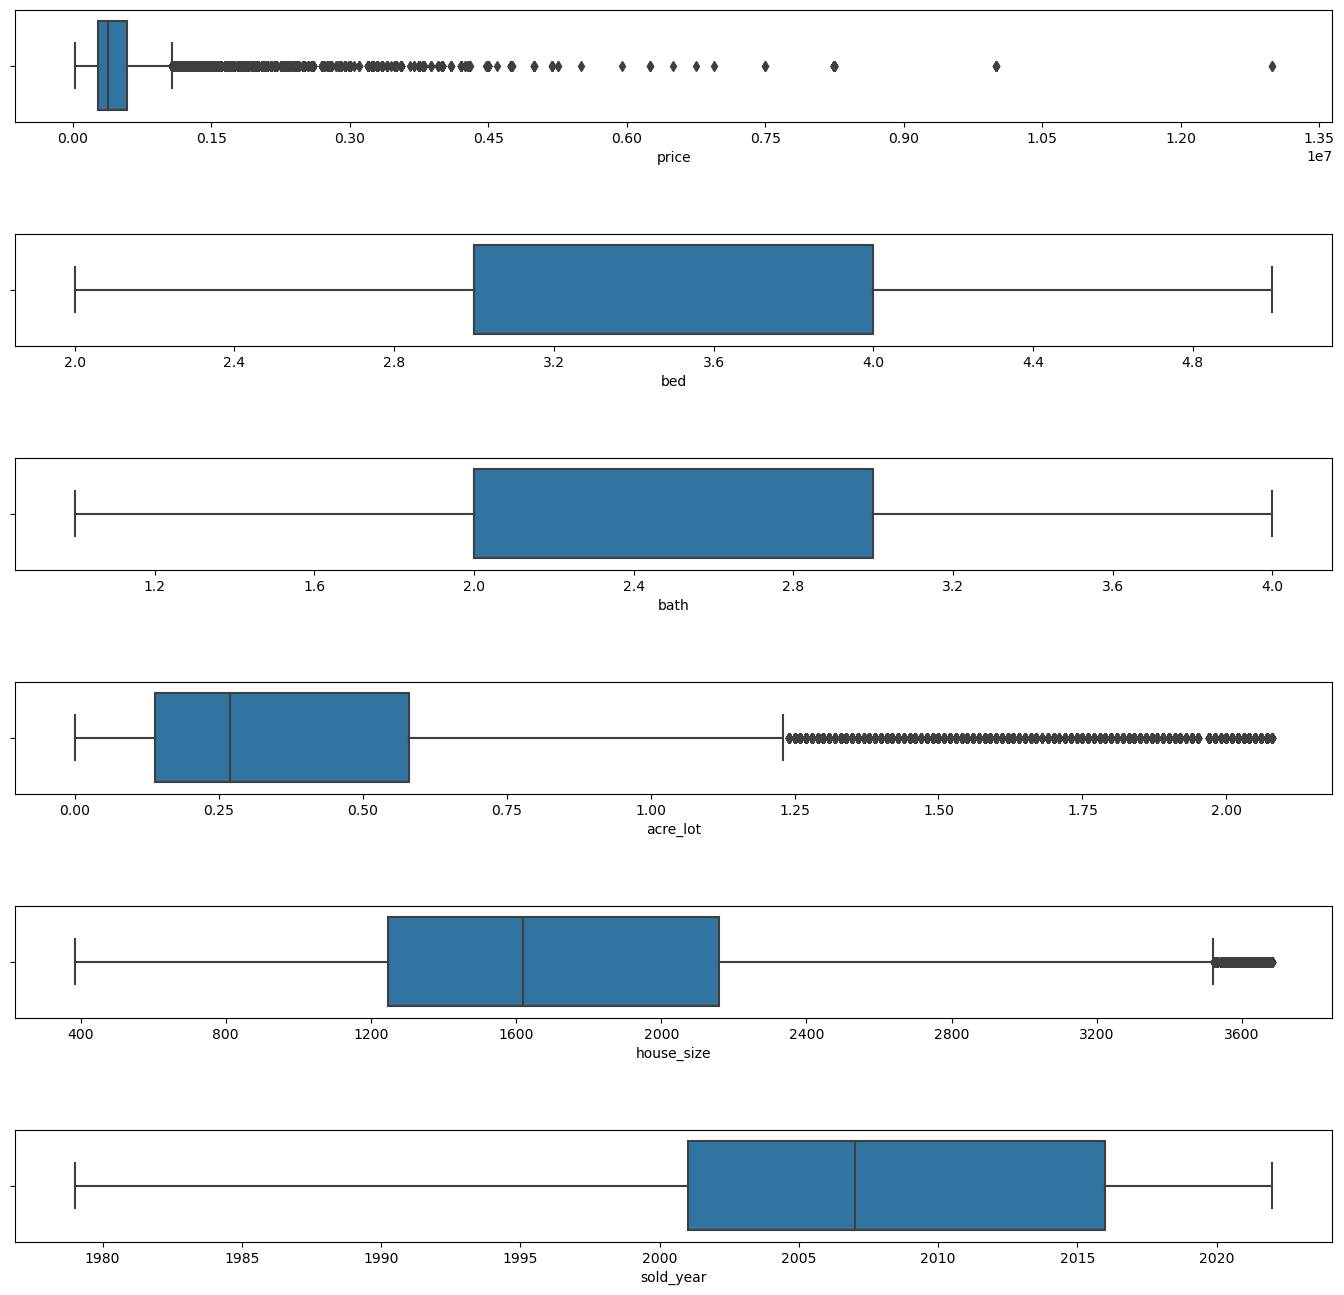

In [75]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,16))
fig.subplots_adjust(hspace=1)
for i, col in enumerate(['price', 'bed', 'bath', 'acre_lot', 'house_size', 'sold_year']):
    sns.boxplot(x=col, data=df_realtor, ax=ax[i])
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) 

Además, eliminaremos aquellas propiedades con un precio más grande, puesto que estas seguramente sean propiedades de lujo y a nosotros nos interesa estudiar el mercado   
de la vivienda habitual

In [76]:
print(f'Tamaño dataset anterior: {df_realtor.shape}')
#Creamos un df con la variable para recortar
variablerecorte = df_realtor[['price']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que elimine los atipicos del nuevo dataframe
df_realtor = df_realtor[
    (df_realtor['price']>=iqr_lim_inf) & (df_realtor['price']<=iqr_lim_sup)
]
print(f'Tamaño dataset recortado: {df_realtor.shape}')

Tamaño dataset anterior: (100826, 8)
Tamaño dataset recortado: (94977, 8)


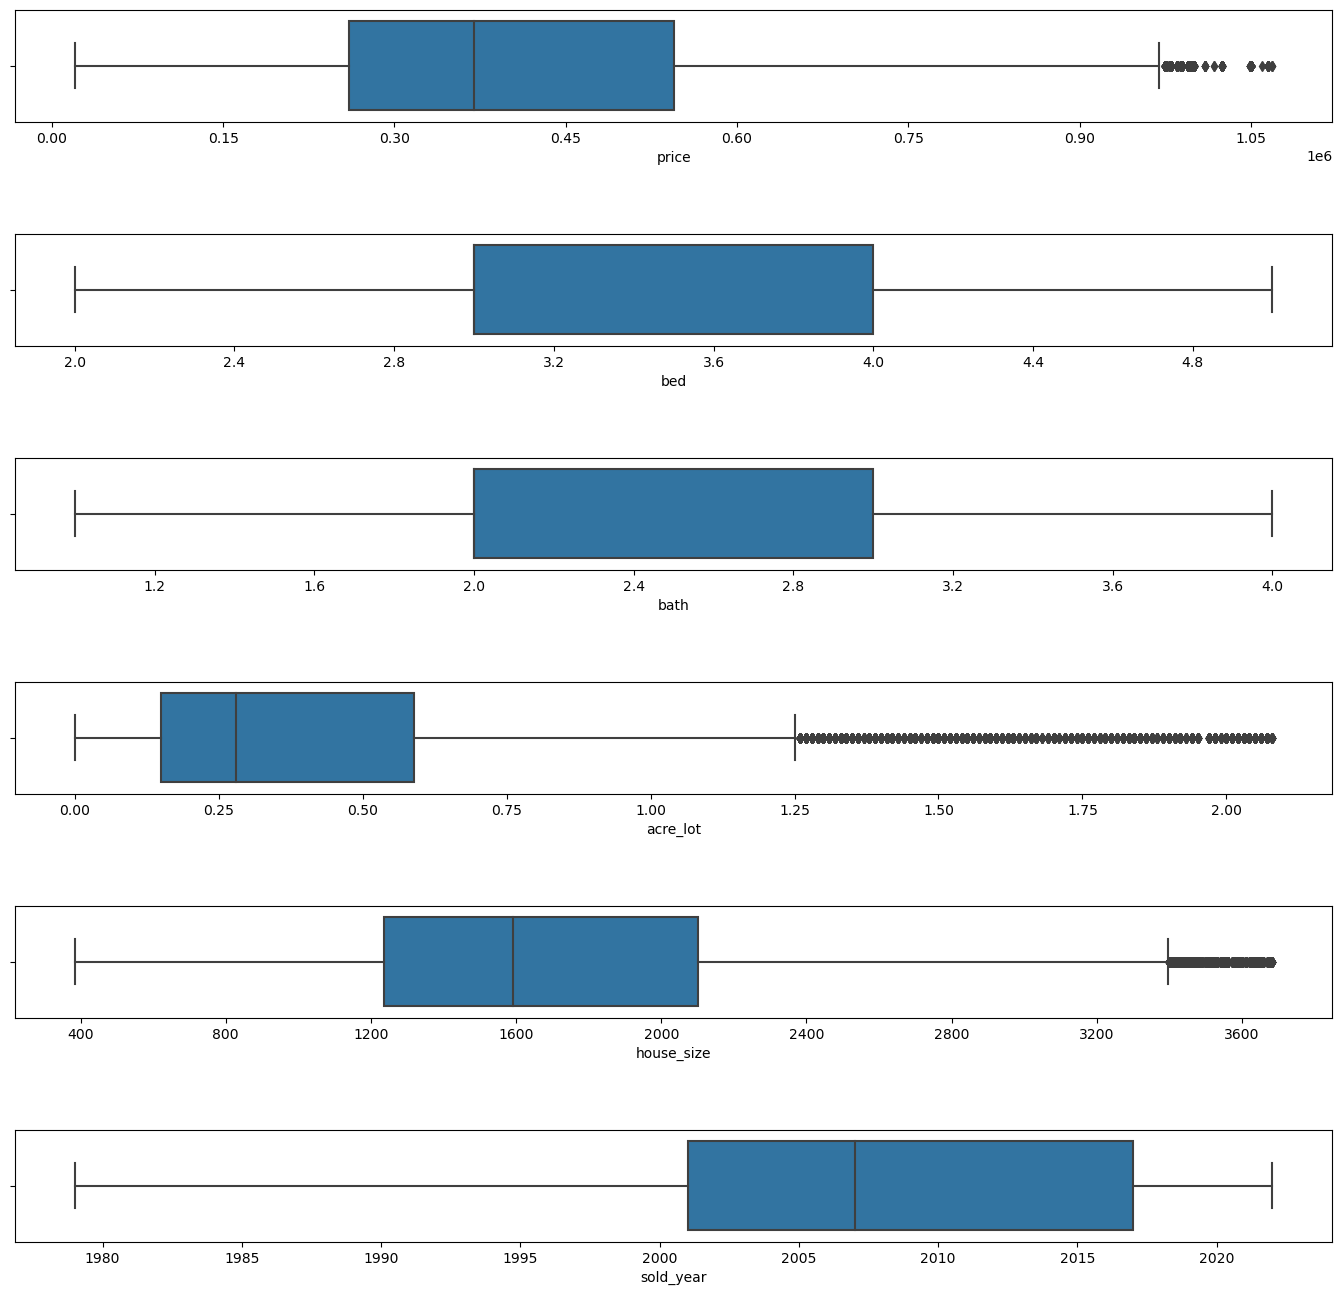

In [77]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,16))
fig.subplots_adjust(hspace=1)
for i, col in enumerate(['price', 'bed', 'bath', 'acre_lot', 'house_size', 'sold_year']):
    sns.boxplot(x=col, data=df_realtor, ax=ax[i])
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) 

Convertimos las variables categóricas a Dummies

In [78]:
df_realtor = pd.get_dummies(df_realtor, columns=['sold_season'])

In [79]:
nombres_antiguos = list(df_realtor.columns[7:13])
nombres_nuevos = []
for i in range(len(nombres_antiguos)):
    nombres_nuevos.append((nombres_antiguos[i])[12:(len(nombres_antiguos[i]))])
cambio_nombres = {}
for i in range(len(nombres_antiguos)):
    cambio_nombres[nombres_antiguos[i]] = nombres_nuevos[i]
df_realtor.rename(columns = cambio_nombres, inplace=True)

In [80]:
df_realtor

,price,bed,bath,acre_lot,state,house_size,sold_year,autumn,spring,summer,winter
24237,525000.0,3,3,0.45,Massachusetts,2314.0,2014,0,0,1,0
24238,289900.0,3,2,0.36,Massachusetts,1276.0,2012,1,0,0,0
24244,384900.0,3,2,0.46,Massachusetts,1476.0,1986,1,0,0,0
24251,199999.0,3,2,1.76,Massachusetts,1968.0,2008,0,0,1,0
24258,419000.0,4,2,2.00,Massachusetts,1607.0,2005,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
512091,795000.0,3,3,0.06,New York,1570.0,1998,0,0,1,0
512127,639000.0,4,2,0.07,New York,1729.0,2018,0,0,1,0
512130,785000.0,3,3,0.11,New York,1920.0,2004,1,0,0,0
512134,929000.0,3,3,0.06,New York,1873.0,1990,0,0,1,0


In [81]:
df_realtor = pd.get_dummies(df_realtor, columns=['state'])

In [82]:
nombres_antiguos = list(df_realtor.columns[11:20])
nombres_nuevos = []
for i in range(len(nombres_antiguos)):
    nombres_nuevos.append((nombres_antiguos[i])[6:(len(nombres_antiguos[i]))])
cambio_nombres = {}
for i in range(len(nombres_antiguos)):
    cambio_nombres[nombres_antiguos[i]] = nombres_nuevos[i]
df_realtor.rename(columns = cambio_nombres, inplace=True)

In [83]:
df_realtor

,price,bed,bath,acre_lot,house_size,sold_year,autumn,spring,summer,winter,state_Connecticut,Maine,Massachusetts,N.Jersey and nearby,New Hampshire,New York,Rhode Island,Vermont
24237,525000.0,3,3,0.45,2314.0,2014,0,0,1,0,0,0,1,0,0,0,0,0
24238,289900.0,3,2,0.36,1276.0,2012,1,0,0,0,0,0,1,0,0,0,0,0
24244,384900.0,3,2,0.46,1476.0,1986,1,0,0,0,0,0,1,0,0,0,0,0
24251,199999.0,3,2,1.76,1968.0,2008,0,0,1,0,0,0,1,0,0,0,0,0
24258,419000.0,4,2,2.00,1607.0,2005,0,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512091,795000.0,3,3,0.06,1570.0,1998,0,0,1,0,0,0,0,0,0,1,0,0
512127,639000.0,4,2,0.07,1729.0,2018,0,0,1,0,0,0,0,0,0,1,0,0
512130,785000.0,3,3,0.11,1920.0,2004,1,0,0,0,0,0,0,0,0,1,0,0
512134,929000.0,3,3,0.06,1873.0,1990,0,0,1,0,0,0,0,0,0,1,0,0


In [84]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94977 entries, 24237 to 512154
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                94977 non-null  float64
 1   bed                  94977 non-null  int32  
 2   bath                 94977 non-null  int32  
 3   acre_lot             94977 non-null  float64
 4   house_size           94977 non-null  float64
 5   sold_year            94977 non-null  int64  
 6   autumn               94977 non-null  uint8  
 7   spring               94977 non-null  uint8  
 8   summer               94977 non-null  uint8  
 9   winter               94977 non-null  uint8  
 10  state_Connecticut    94977 non-null  uint8  
 11  Maine                94977 non-null  uint8  
 12  Massachusetts        94977 non-null  uint8  
 13  N.Jersey and nearby  94977 non-null  uint8  
 14  New Hampshire        94977 non-null  uint8  
 15  New York             94977 non-

In [85]:
df_realtor

,price,bed,bath,acre_lot,house_size,sold_year,autumn,spring,summer,winter,state_Connecticut,Maine,Massachusetts,N.Jersey and nearby,New Hampshire,New York,Rhode Island,Vermont
24237,525000.0,3,3,0.45,2314.0,2014,0,0,1,0,0,0,1,0,0,0,0,0
24238,289900.0,3,2,0.36,1276.0,2012,1,0,0,0,0,0,1,0,0,0,0,0
24244,384900.0,3,2,0.46,1476.0,1986,1,0,0,0,0,0,1,0,0,0,0,0
24251,199999.0,3,2,1.76,1968.0,2008,0,0,1,0,0,0,1,0,0,0,0,0
24258,419000.0,4,2,2.00,1607.0,2005,0,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512091,795000.0,3,3,0.06,1570.0,1998,0,0,1,0,0,0,0,0,0,1,0,0
512127,639000.0,4,2,0.07,1729.0,2018,0,0,1,0,0,0,0,0,0,1,0,0
512130,785000.0,3,3,0.11,1920.0,2004,1,0,0,0,0,0,0,0,0,1,0,0
512134,929000.0,3,3,0.06,1873.0,1990,0,0,1,0,0,0,0,0,0,1,0,0


### Separación e inspección de los datos 

In [86]:
X = df_realtor.drop('price', axis=1)

y = df_realtor.price

Como tarda mucho en generar el pairplot, vamos a guardarlo en imagen.  
El código para generarlo sería:  
sns.pairplot(X, diag_kind='kde');  
![Output2](output2.png)

In [87]:
# normalización

X[X.columns] = StandardScaler().fit_transform(X)

In [88]:
X.head()

,bed,bath,acre_lot,house_size,sold_year,autumn,spring,summer,winter,state_Connecticut,Maine,Massachusetts,N.Jersey and nearby,New Hampshire,New York,Rhode Island,Vermont
24237,-0.323483,1.101561,-0.015077,0.949468,0.658837,-0.604351,-0.570246,1.538281,-0.484361,-0.738629,-0.178979,1.402039,-0.150807,-0.273521,-0.181841,-0.344671,-0.226378
24238,-0.323483,-0.156925,-0.214326,-0.699240,0.451339,1.654668,-0.570246,-0.650076,-0.484361,-0.738629,-0.178979,1.402039,-0.150807,-0.273521,-0.181841,-0.344671,-0.226378
24244,-0.323483,-0.156925,0.007062,-0.381570,-2.246136,1.654668,-0.570246,-0.650076,-0.484361,-0.738629,-0.178979,1.402039,-0.150807,-0.273521,-0.181841,-0.344671,-0.226378
24251,-0.323483,-0.156925,2.885111,0.399899,0.036343,-0.604351,-0.570246,1.538281,-0.484361,-0.738629,-0.178979,1.402039,-0.150807,-0.273521,-0.181841,-0.344671,-0.226378
24258,0.962823,-0.156925,3.416443,-0.173496,-0.274904,-0.604351,-0.570246,1.538281,-0.484361,-0.738629,-0.178979,1.402039,-0.150807,-0.273521,-0.181841,-0.344671,-0.226378


In [89]:
# separacion en paquetes de entrenamiento y testeo

X_train, X_test, y_train, y_test = tts(X, y)

In [90]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((71232, 17), (23745, 17), (71232,), (23745,))

### Modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. 

In [91]:
model = Sequential()

model.add(Dense(64,  #64 neuronas
                activation='relu',     #Función de activación, relu = unidad de rectificado lineal
                input_shape=[X_train.shape[1]])) # lAS COLUMNas del df, 9 en este caso
model.add(Dense(64, activation='relu')) 

model.add(Dense(1))



optimizer = RMSprop(0.001)



model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])  

In [92]:
# inspeccion del modelo

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5377 (21.00 KB)
Trainable params: 5377 (21.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Entrenamiento**

In [93]:
model.fit(X_train[:20], y_train[:20], epochs=2)

Epoch 1/2
1/1 [==============================] - 2s 2s/step - loss: 240276373504.0000 - mae: 443204.1875 - mse: 240276373504.0000
Epoch 2/2
1/1 [==============================] - 0s 10ms/step - loss: 240276291584.0000 - mae: 443204.0938 - mse: 240276291584.0000


In [94]:
class PrintDot(Callback):
    
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: 
        print('')
    else:
        print('.', end='')

In [95]:
EPOCAS = 1000

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=EPOCAS, 
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[PrintDot()])


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
................................

In [ ]:
history

### Resultados

In [ ]:
pd.DataFrame(history.history).head()

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [price]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([130000,175000])
    plt.legend()
    
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$price^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([37000000000,60000000000])
    plt.legend()
    
    plt.show();

In [ ]:
plot_history(history)

Este gráfico ha salido mejor que el gráfico de clase en cuanto al el error de validación. No obstante se observa que después de 700 épocas, el error de validación comienza a degradarse. 

Vamos a hacer lo que hemos visto en clase.
Actualicemos la llamada `model.fit` para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una * devolución de llamada de EarlyStopping * que pruebe una condición de entrenamiento para cada época. 

In [ ]:
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=[X_train.shape[1]]))

model.add(Dense(64, activation='relu'))

model.add(Dense(1))


optimizer = RMSprop(0.001)


model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])  

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=EPOCAS, 
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[early_stop, PrintDot()])

In [ ]:
plot_history(history)

A raíz de los gráficos, vemos que se ha mejorado un poco, Al haber menos épocas el error de validación no ha ido degradándose.

Veamos qué tan bien generaliza el modelo al usar el conjunto de testeo, que no usamos al entrenar el modelo. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real.

### Predicciones

In [ ]:
y_pred = model.predict(X_test).flatten()

In [ ]:
y_pred[:10]

In [ ]:
plt.scatter(y_test, y_pred)

plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')

plt.axis('equal')
plt.axis('square')

plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])

_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=1)

print('Testing MAE: {:5.2f} Price'.format(mae))
print('Testing RMSE: {:5.2f} Price'.format(mse**0.5))

Parece ser que el modelo no es muy bueno. Analicemos las métricas:  
- loss: 40532807680.0000 - Esta es la función de pérdida (o error) que el modelo ha obtenido en el conjunto de datos de prueba. 
    Mide la discrepancia entre las predicciones del modelo y los valores reales. En este caso, el valor es bastante grande. 
    Al estár prediciendo precios en el rango de millones, este error podría ser razonable. 
- mse: 40532807680.0000 - MSE significa Error Cuadrático Medio. Esta métrica es similar a la función de pérdida.  
  El MSE penaliza los errores grandes más que el MAE, porque los errores se elevan al cuadrado antes de calcular el promedio.
- Testing MAE: 142789.27 Price MAE significa Error Absoluto Medio. Otra métrica que se utiliza para cuantificar cuán lejos  
  están las predicciones del modelo de los valores verdaderos. En este caso, en promedio, laspredicciones se desvían en    142789.27 de los valores reales
- Testing RMSE: 201327.61 Price - RMSE es la raíz cuadrada del Error Cuadrático Medio. Esta métrica es útil porque tiene las  
  mismas unidades que la variable que se está predicioendo, lo que a veces la hace más interpretable que el MSE.  

Estas métricas sugieren que hay margen para mejorar el modelo. Para mejorarlo, podríamos sólo haber tomado los datos de las viviendas que realmente se han vendido y haber recortado atípicos en lugar de ajustar.  
En resumen, parece que hemos incluido datos que aportan más bien poco.

In [ ]:
y.mean(), y.std()

In [ ]:
error = y_pred - y_test

plt.hist(error, bins = 25)

plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

No es del todo gaussiano, pero se aproxima bastante

## Conclusion

Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.